In [1]:
# Imports
# !pip install torchinfo
import torch
import torch.nn as nn
import torch.utils.data as Data
from torchvision import datasets, transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import os
# os.environ['OPENBLAS_NUM_THREADS'] = '1'
import numpy as np
import random
import time
import TrainerVTS_V08C1 as TP
import DataSetting_v2 as DS

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

### Loader

In [8]:
gpu = 5
date = '240527'
#run = ['30', '100', '300', '900']
run = '30'
exp = 'Prop_Teacher_OF'

In [3]:
datadir = f'../dataset/0509/make19_{run}-finished/'
data = DS.ModalityLoader(data_dir=datadir, mmap_mode='r')
train = data.profiling({'T01', 'T02'})
test = data.profiling({'T03', 'T04'})
train_set = DS.MyDataset('tv', train)
test_set = DS.MyDataset('test', test)
train_loader, valid_loader = DS.DataSplitter(train_set).split_loader()
test_loader = DS.DataSplitter(test_set, 1).gen_loader()

Loading from ../dataset/0509/make19_30-finished/


  0%|          | 0/10 [00:00<?, ?it/s]

Profiled by {'T01', 'T02'}
Profiled by {'T03', 'T04'}
Generating loaders...
 tv len 5490, distributed=False
 exported train loader of len 68, batch size 64
 exported valid loader of len 17, batch size 64

Generating loaders...
 test len 5069, distributed=False
 exported loader of len 5069, batch size 1


### Teacher

In [11]:
torch.cuda.set_device(gpu)
imgencoder = TP.ImageEncoder(latent_dim=16)
imgdecoder = TP.ImageDecoder(latent_dim=16)

T_trainer = TP.TeacherTrainer(beta=0.5, 
                              mask=True,
                              recon_lossfunc=nn.MSELoss(reduction='sum'),
                              name='Teacher', networks=[imgencoder, imgdecoder],
                              lr=1e-4, epochs=10, cuda=gpu,
                              train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader,
                              notion=f"{date}_{run}_{exp}")

Teacher train: epoch=1/999, batch=0/68, loss=4240.3960, current best valid loss=inf    
Teacher train: epoch=1/999, batch=5/68, loss=4153.6807, current best valid loss=inf    
Teacher train: epoch=1/999, batch=10/68, loss=3669.2854, current best valid loss=inf    
Teacher train: epoch=1/999, batch=15/68, loss=2708.7659, current best valid loss=inf    
Teacher train: epoch=1/999, batch=20/68, loss=2508.7029, current best valid loss=inf    
Teacher train: epoch=1/999, batch=25/68, loss=2466.4258, current best valid loss=inf    
Teacher train: epoch=1/999, batch=30/68, loss=1702.9540, current best valid loss=inf    
Teacher train: epoch=1/999, batch=35/68, loss=1586.7648, current best valid loss=inf    
Teacher train: epoch=1/999, batch=40/68, loss=1279.3195, current best valid loss=inf    
Teacher train: epoch=1/999, batch=45/68, loss=1335.4388, current best valid loss=inf    
Teacher train: epoch=1/999, batch=50/68, loss=1096.3569, current best valid loss=inf    
Teacher train: epoch=1/

<Figure size 432x288 with 0 Axes>

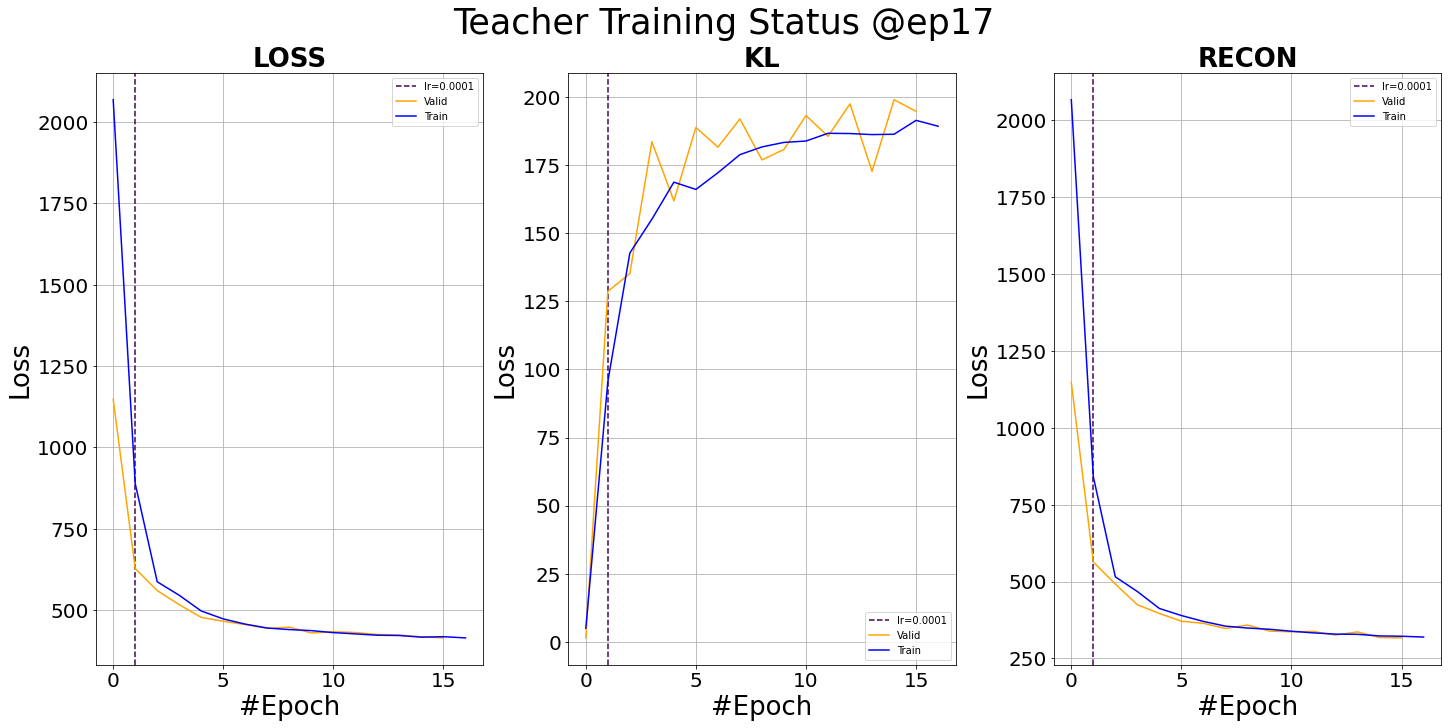

Teacher test: sample=65/68, loss=99.6776     
Test finished. Average loss={'LOSS': 316.9765755919849, 'KL': 3.0903350613353884, 'RECON': 315.43140806871304}

Total training time: 18.772018909454346 sec


<Figure size 1440x720 with 0 Axes>

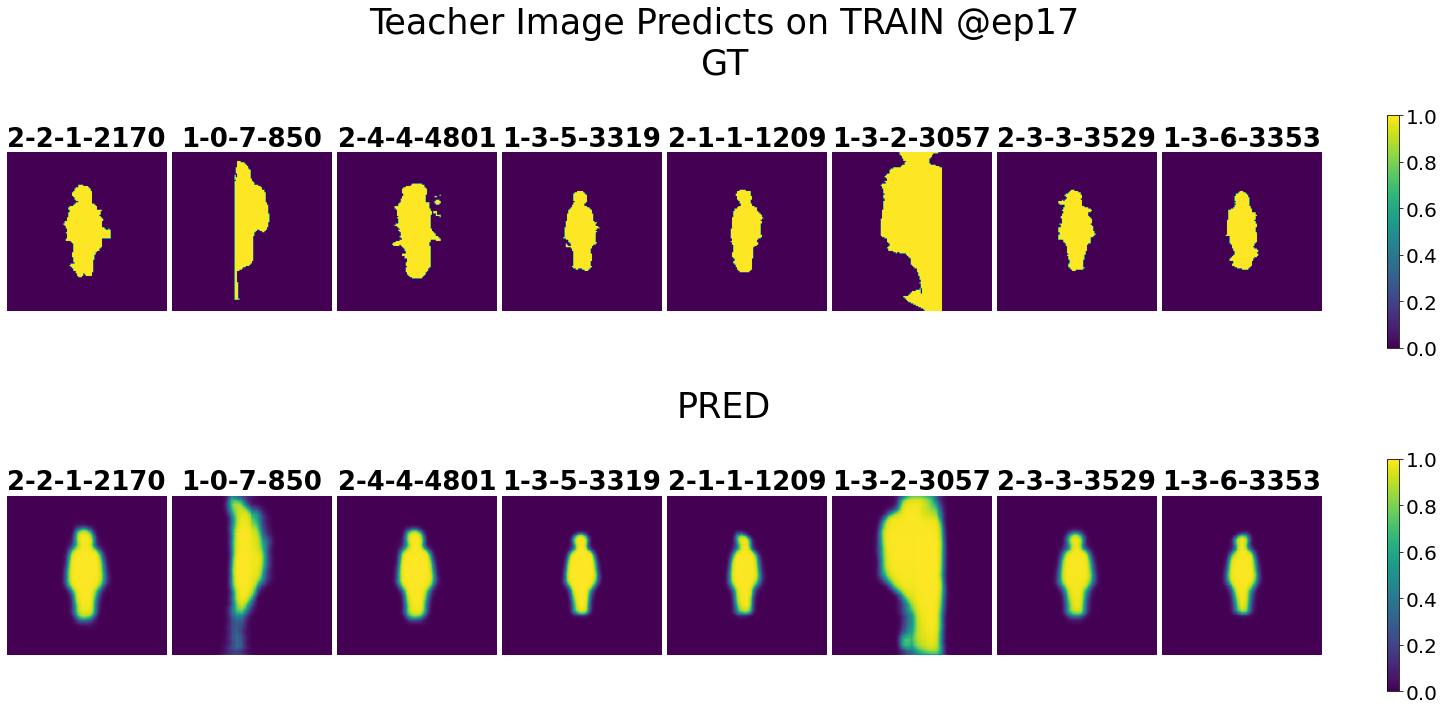

<Figure size 1440x720 with 0 Axes>

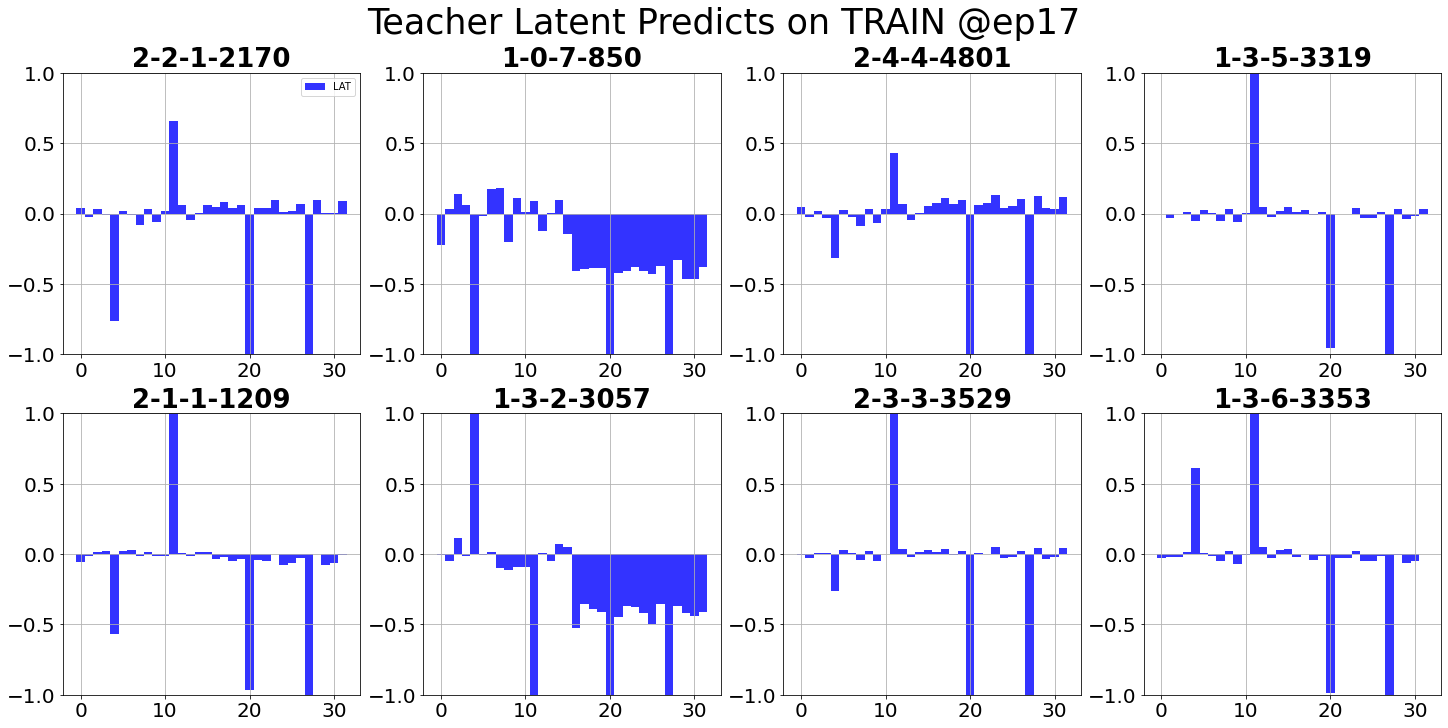

Teacher test: sample=5065/5069, loss=546.7331     
Test finished. Average loss={'LOSS': 562.65524629588, 'KL': 2.8829582555685835, 'RECON': 561.2137673611848}

Total training time: 46.2993597984314 sec


<Figure size 1440x720 with 0 Axes>

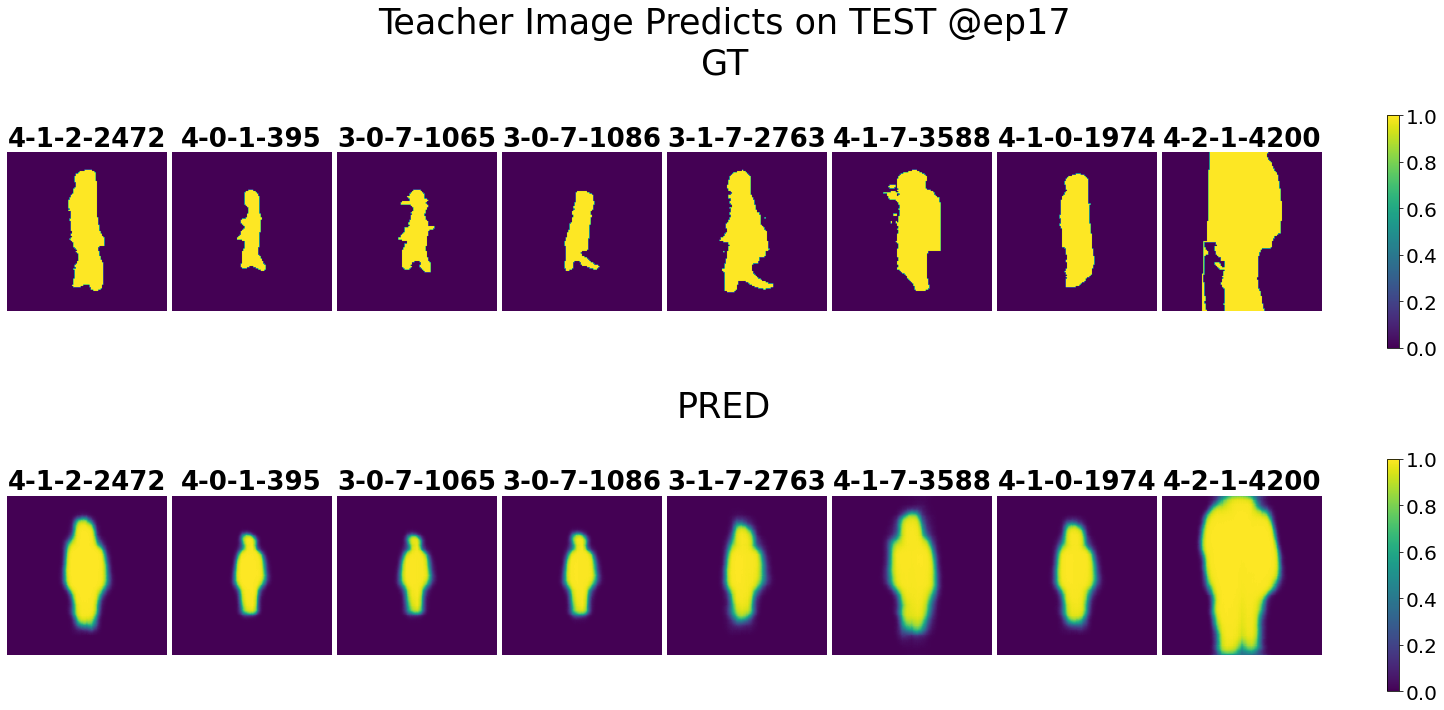

<Figure size 1440x720 with 0 Axes>

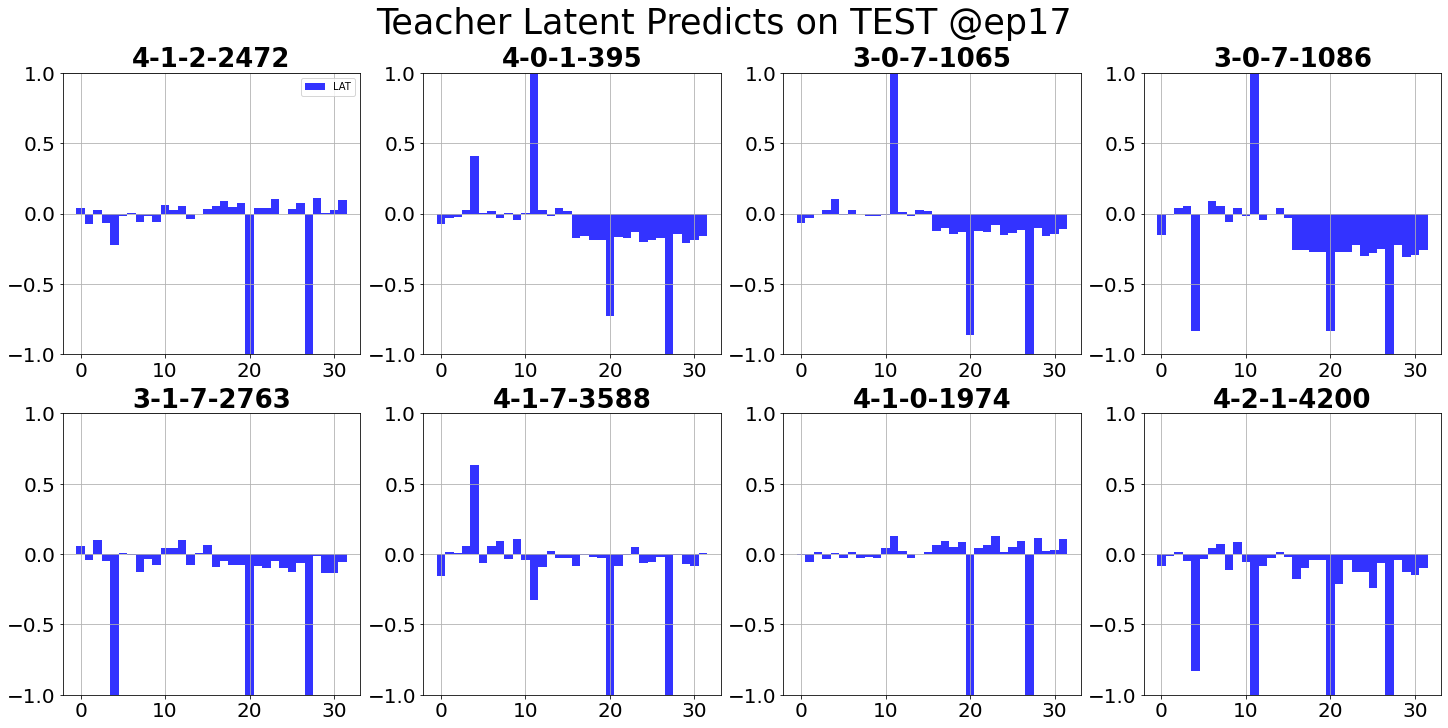

Saving pred including GT, PRED, LAT, TAG...Done

Teacher schedule Completed!


In [12]:
### Scheduler
%matplotlib inline
T_trainer.lr = 1e-4
T_trained = T_trainer.schedule(lr_decay=False)

### Student

In [6]:
torch.cuda.set_device(gpu)
csiencoder = TP.CSIEncoder(lstm_steps=7)
centerdecoder = TP.CenterDecoder()
imgencoder = TP.ImageEncoder(latent_dim=16)
imgdecoder = TP.ImageDecoder(latent_dim=16)
imgencoder.load_state_dict(torch.load(f"../saved/240523_30_Prop-Teacher/Teacher_IMGENV08C1_best.pth"))
imgdecoder.load_state_dict(torch.load(f"../saved/240523_30_Prop-Teacher/Teacher_IMGDEV08C1_best.pth"))
#imgencoder = T_trained['imgen']
#imgdecoder = T_trained['imgde']

S_trainer = TP.StudentTrainer(name='Student', mask=True,
                              networks=[csiencoder, centerdecoder, imgencoder, imgdecoder],
                              lr=1e-4, epochs=10, cuda=gpu,
                              notion=f"{date}_{run}_{exp}",
                              train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader,
                             )

Student train: epoch=1/999, batch=0/68, loss=0.3255, current best valid loss=inf    
Student train: epoch=1/999, batch=5/68, loss=0.2452, current best valid loss=inf    
Student train: epoch=1/999, batch=10/68, loss=0.1945, current best valid loss=inf    
Student train: epoch=1/999, batch=15/68, loss=0.2014, current best valid loss=inf    
Student train: epoch=1/999, batch=20/68, loss=0.1825, current best valid loss=inf    
Student train: epoch=1/999, batch=25/68, loss=0.1695, current best valid loss=inf    
Student train: epoch=1/999, batch=30/68, loss=0.1552, current best valid loss=inf    
Student train: epoch=1/999, batch=35/68, loss=0.1517, current best valid loss=inf    
Student train: epoch=1/999, batch=40/68, loss=0.1390, current best valid loss=inf    
Student train: epoch=1/999, batch=45/68, loss=0.1578, current best valid loss=inf    
Student train: epoch=1/999, batch=50/68, loss=0.1514, current best valid loss=inf    
Student train: epoch=1/999, batch=55/68, loss=0.1453, cu

<Figure size 432x288 with 0 Axes>

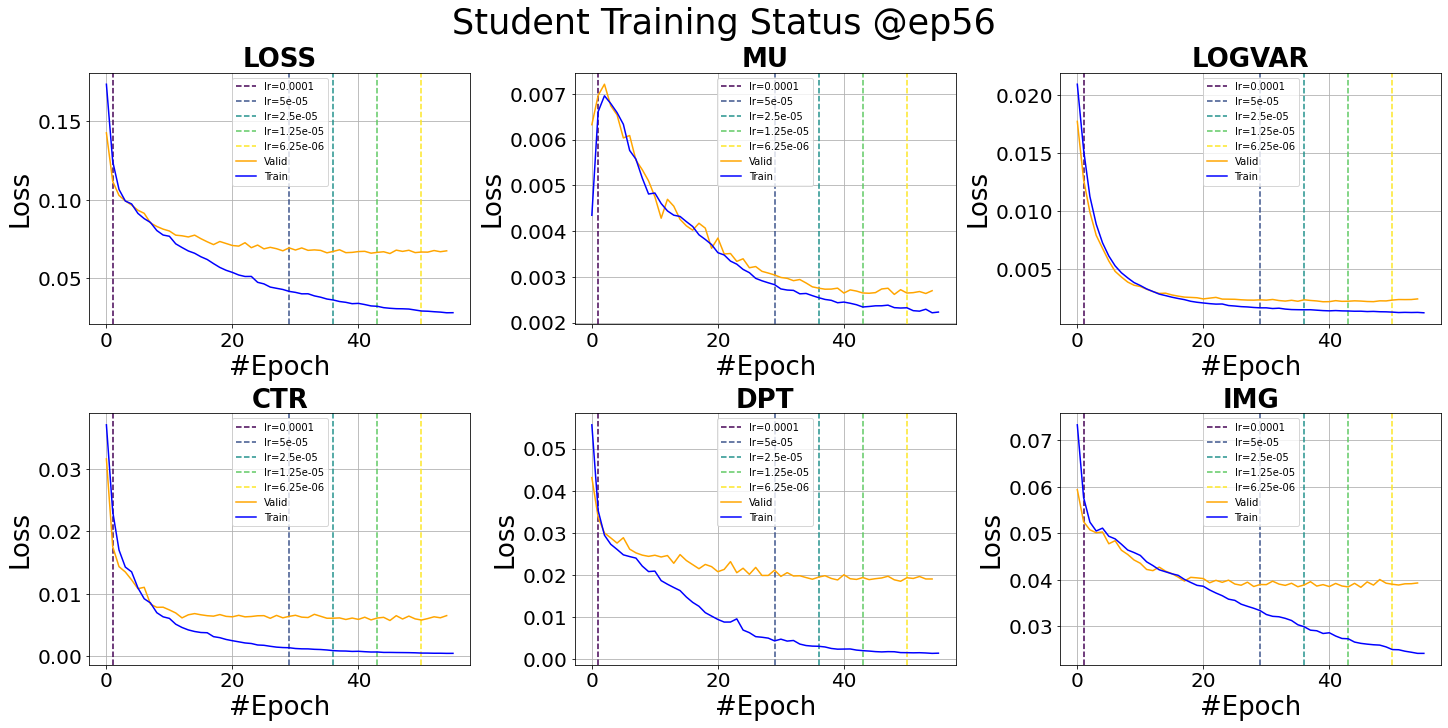

/home/bob/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/bob/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Student test: sample=65/68, loss=0.0387    
Test finished. Average loss={'LOSS': 0.1518998208525505, 'MU': 0.14129213989426984, 'LOGVAR': 0.0782941668503019, 'CTR': 0.0003387847314409671, 'DPT': 0.0009413509194714505, 'IMG': 0.021927137811657945}

Total training time: 37.40038466453552 sec


<Figure size 1440x720 with 0 Axes>

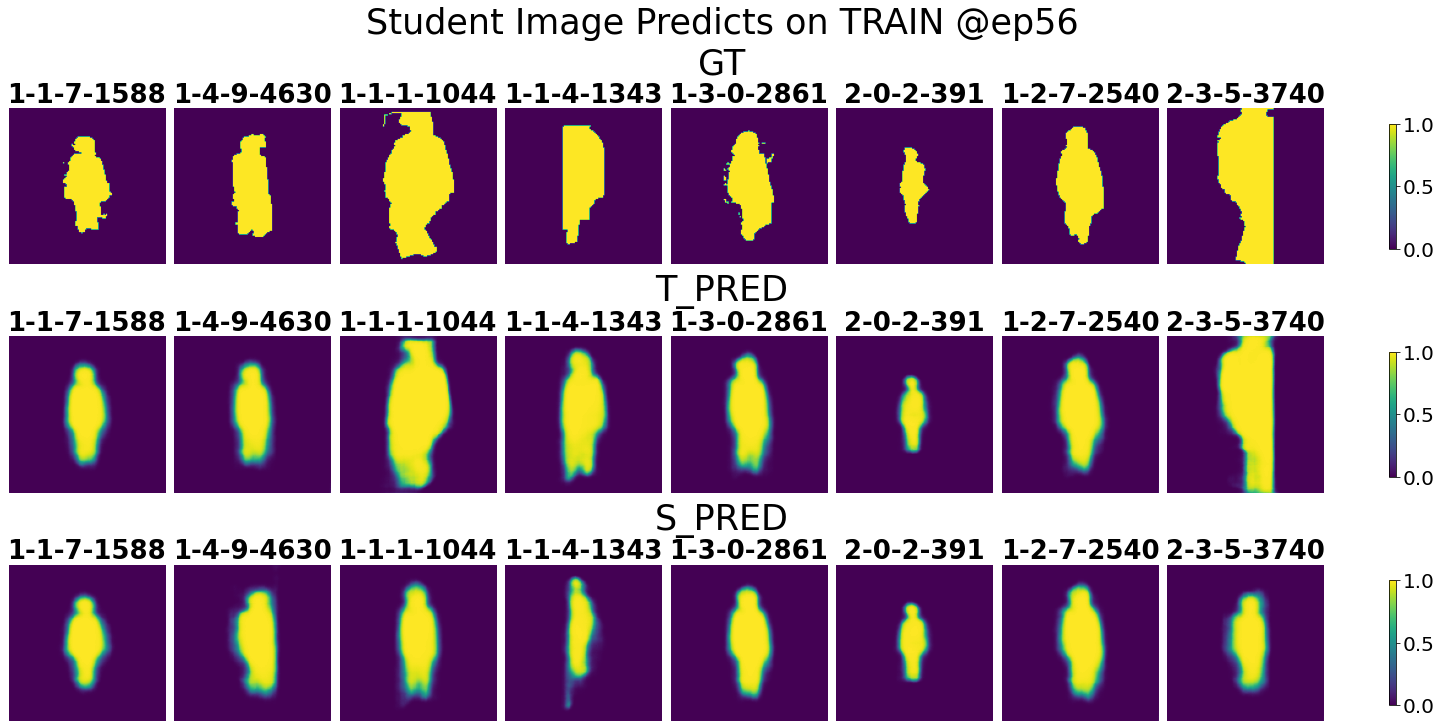

<Figure size 1440x720 with 0 Axes>

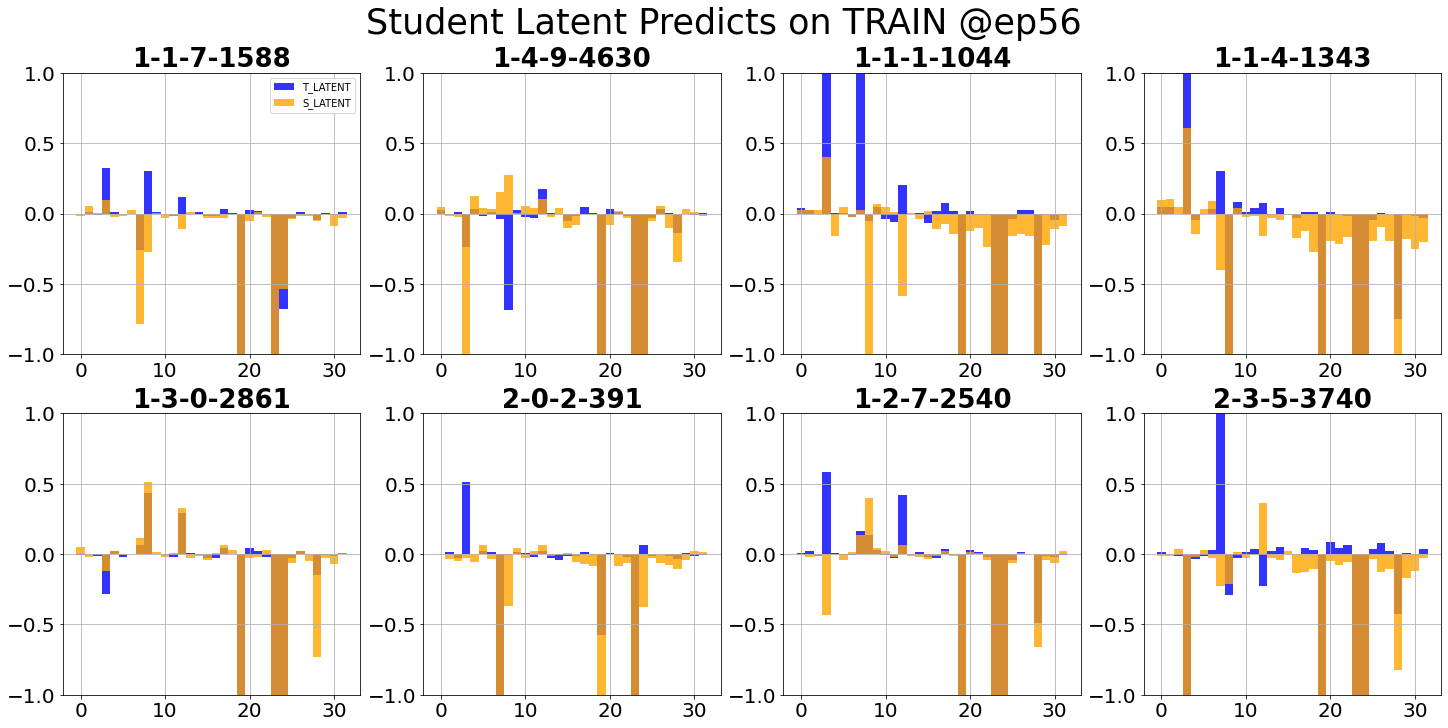

<Figure size 1440x720 with 0 Axes>

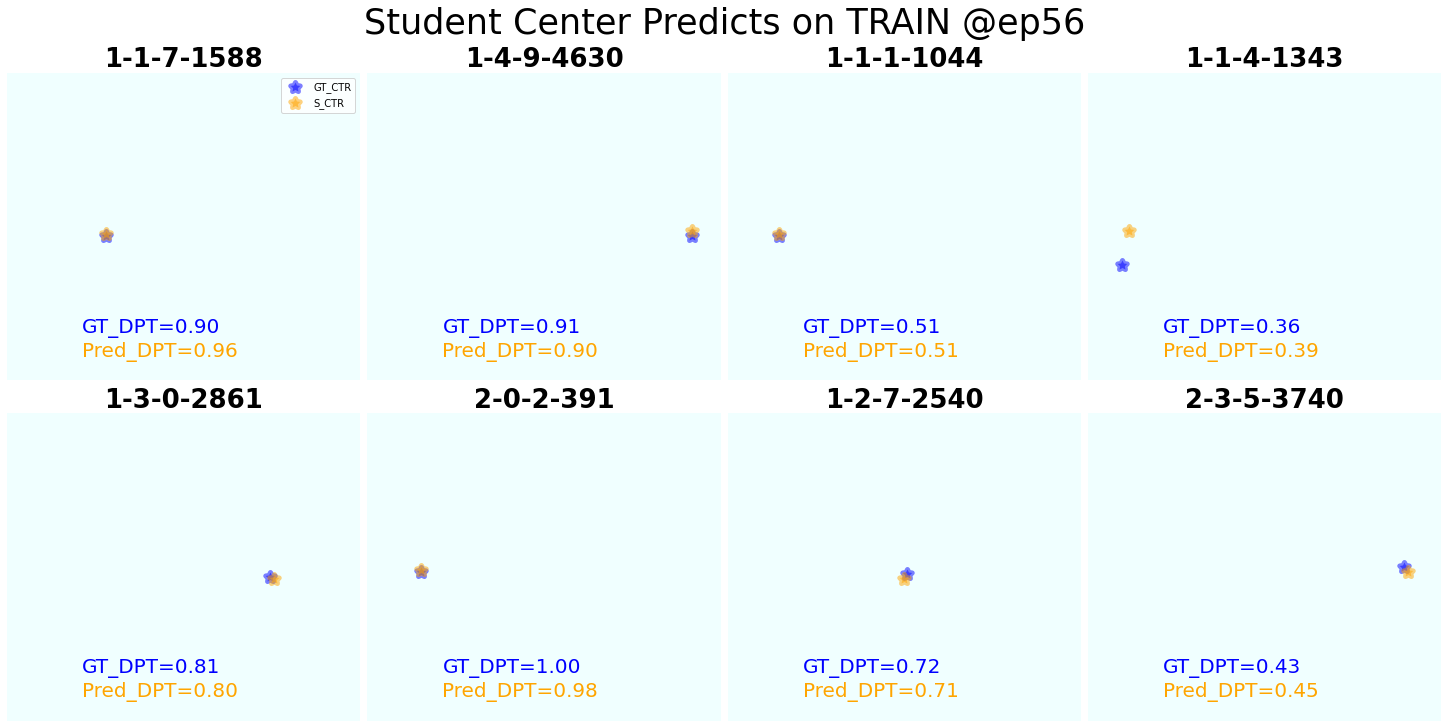

<Figure size 1440x720 with 0 Axes>

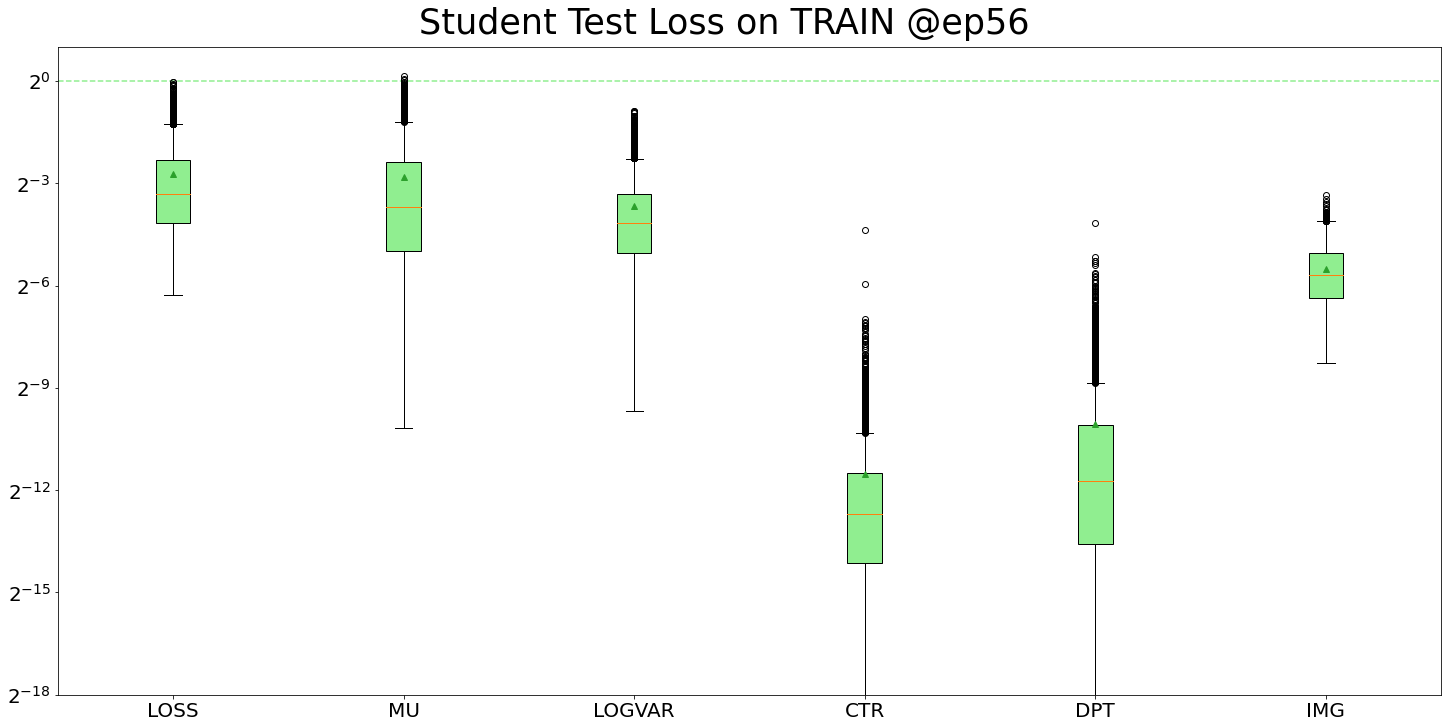

<Figure size 1440x720 with 0 Axes>

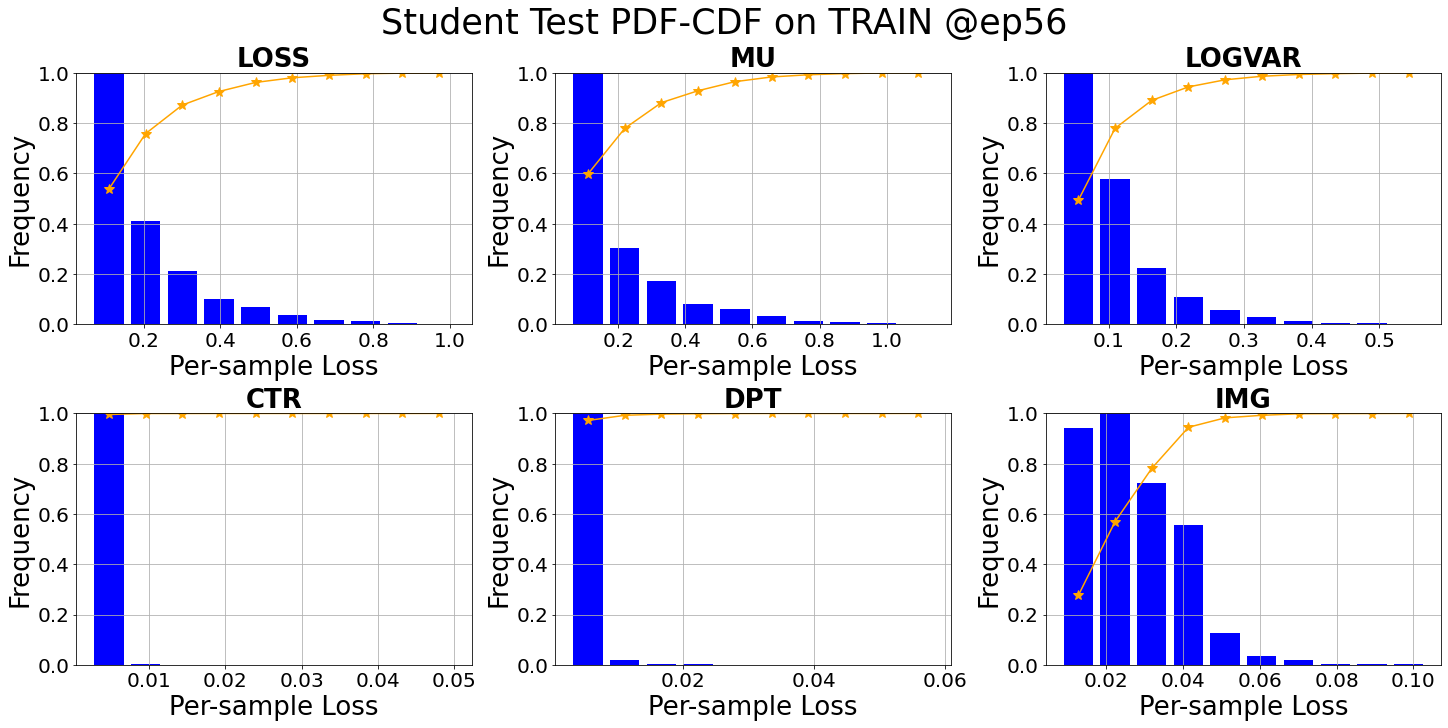

Student test: sample=5/5069, loss=0.5788    

/home/bob/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/bob/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Student test: sample=5065/5069, loss=0.1885    
Test finished. Average loss={'LOSS': 0.31364099726538014, 'MU': 0.20164918331883402, 'LOGVAR': 0.2541104716617279, 'CTR': 0.012589552094078109, 'DPT': 0.032176748281653775, 'IMG': 0.056733252242145794}

Total training time: 70.6853187084198 sec


<Figure size 1440x720 with 0 Axes>

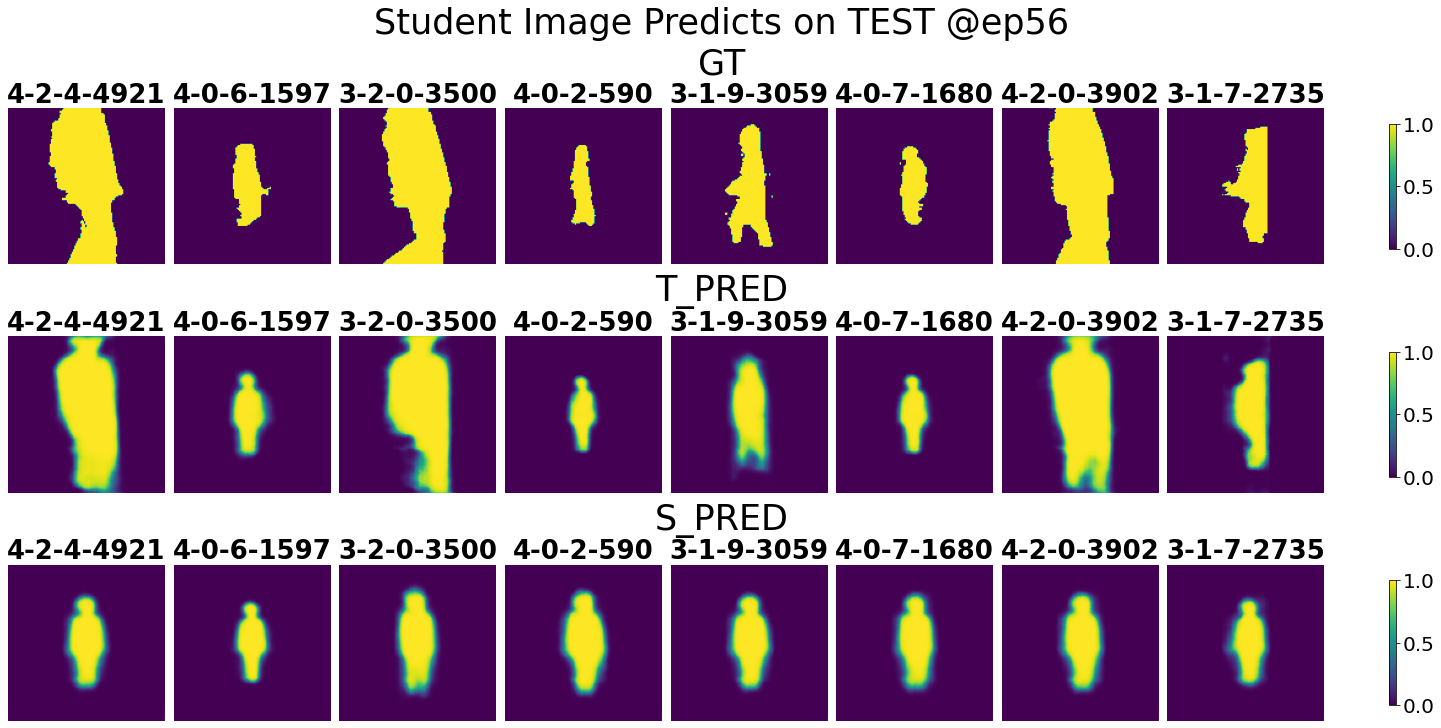

<Figure size 1440x720 with 0 Axes>

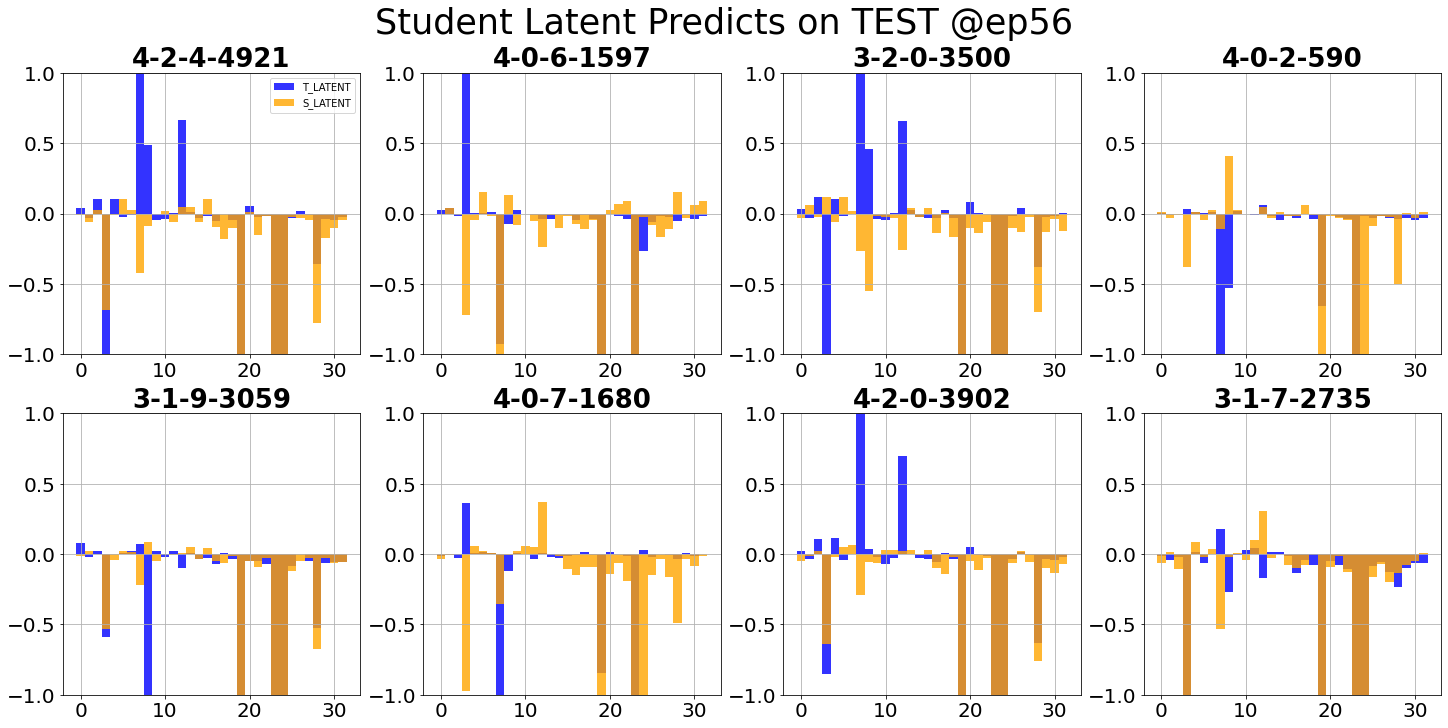

<Figure size 1440x720 with 0 Axes>

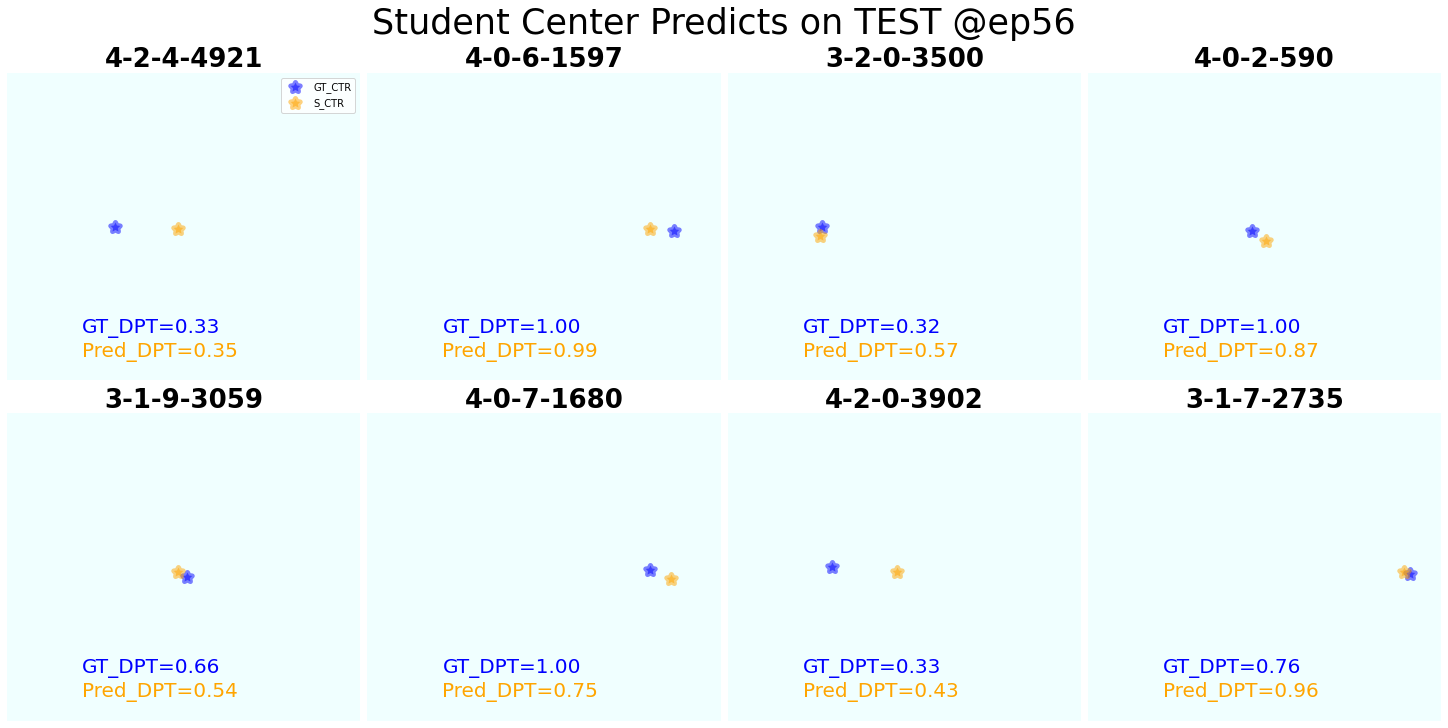

<Figure size 1440x720 with 0 Axes>

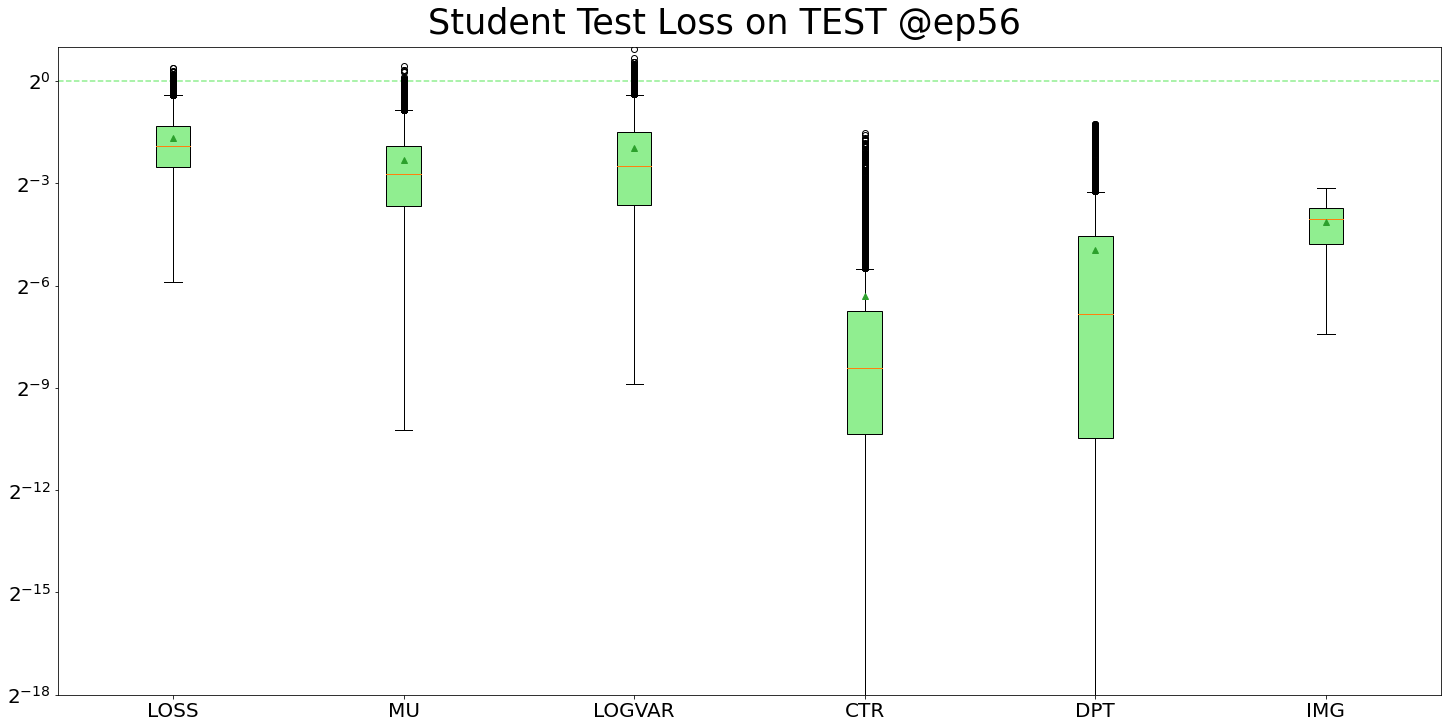

<Figure size 1440x720 with 0 Axes>

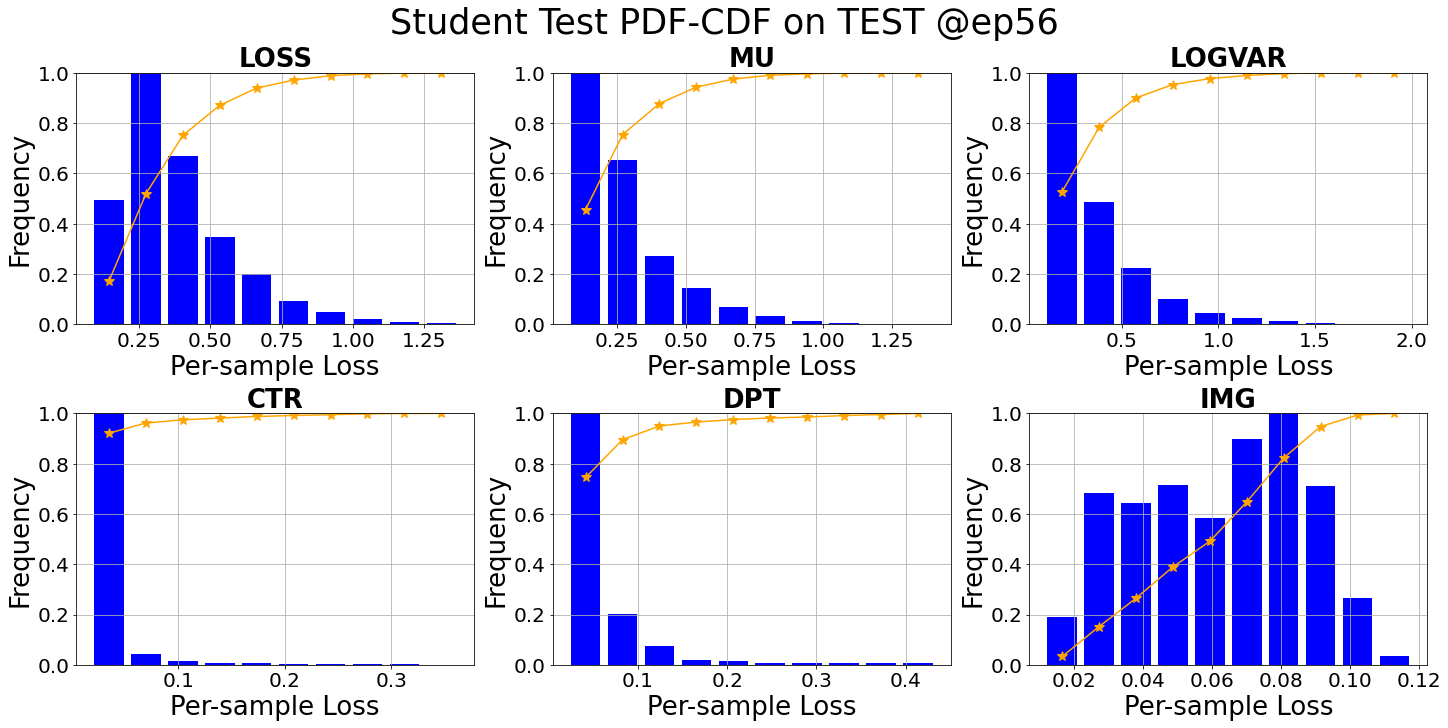

Saving pred including GT, T_PRED, S_PRED, T_LATENT, S_LATENT, GT_CTR, S_CTR, GT_DPT, S_DPT, TAG...Done

Student schedule Completed!


In [7]:
### Scheduler
%matplotlib inline
S_trainer.lr = 1e-4
S_trained = S_trainer.schedule(lr_decay=True, train_module={'csien', 'ctrde'}, eval_module={'imgen', 'imgde'})